# Analysing the calibration of the Perch_v2 model on BirdSet

In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
# Load predictions from each test set by looping over all folders in /workspace/logs/predictions/convnext_bs and load the .pkl files

# load data in dict form: data[<dataset_name>] = (predictions, targets, metadata)
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_dump

data = {}

log_dir = "/workspace/logs/predictions/perch_v2"
dataset_names = sorted(
    [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
)

# colormap without red (tab10 index 3 is red)
colors = plt.cm.tab10
skip_index = 3
available_indices = [i for i in range(colors.N) if i != skip_index]
dataset_colors = {}

for i, ds in enumerate(dataset_names):
    data[ds] = {}
    color_idx = available_indices[i % len(available_indices)]
    dataset_colors[ds] = colors(color_idx)

    ds_path = os.path.join(log_dir, ds)
    pkl_files = [f for f in os.listdir(ds_path) if f.endswith(".pkl")]
    if not pkl_files:
        continue
    # pick most recent file
    pkl_files.sort(
        key=lambda f: os.path.getmtime(os.path.join(ds_path, f)), reverse=True
    )
    file_path = os.path.join(ds_path, pkl_files[0])
    preds, t, metadata = load_dump(file_path)
    data[ds]["predictions"] = preds
    data[ds]["targets"] = t.int()
    data[ds]["metadata"] = metadata
    data[ds]["color"] = dataset_colors[ds]

# concatenate
valid_keys = [
    k
    for k, v in data.items()
    if isinstance(v, dict)
    and "predictions" in v
    and "targets" in v
    and isinstance(v["predictions"], torch.Tensor)
    and isinstance(v["targets"], torch.Tensor)
]

if not valid_keys:
    raise ValueError("No datasets with both 'predictions' and 'targets' present.")

# optionally report skipped datasets
skipped = [k for k in data.keys() if k not in valid_keys]
if skipped:
    print("Skipped datasets (missing predictions/targets):", skipped)

predictions = torch.cat([data[k]["predictions"] for k in valid_keys], dim=0)
targets = torch.cat([data[k]["targets"] for k in valid_keys], dim=0)

data = {k: data[k] for k in valid_keys}

predictions.shape, targets.shape

/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Model info: {'model_source': 'https://www.kaggle.com/models/google/bird-vocalization-classifier/tensorFlow2/perch_v2/2', 'class_name': 'PerchV2TFHub', 'num_classes': 9736}
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Model info: {'model_source': 'https://www.kaggle.com/models/google/bird-vocalization-classifier/tensorFlow2/perch_v2/2', 'class_name': 'PerchV2TFHub', 'num_classes': 9736}
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Model info: {'model_source': 'https://www.kaggle.com/models/google/bird-vocalization-classifier/tensorFlow2/perch_v2/2', 'class_name': 'PerchV2TFHub', 'num_classes': 9736}
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Model info: {'model_so

(torch.Size([322292, 9736]), torch.Size([322292, 9736]))

In [3]:
data["NBP"].keys()

dict_keys(['predictions', 'targets', 'metadata', 'color'])

In [4]:
# print class stats for SSW
from uncertainbird.utils.plotting import print_classwise_statistics

print_classwise_statistics(data["NBP"]["predictions"], data["NBP"]["targets"])

Class 1209: mean: 0.0025, std: 0.0108, min: 0.0000, max: 0.1633, positive samples: 8
Class 1245: mean: 0.0100, std: 0.0933, min: 0.0000, max: 0.9788, positive samples: 9
Class 1249: mean: 0.0048, std: 0.0520, min: 0.0000, max: 0.8390, positive samples: 8
Class 2471: mean: 0.0105, std: 0.0708, min: 0.0000, max: 0.9447, positive samples: 10
Class 3176: mean: 0.0106, std: 0.0844, min: 0.0000, max: 0.9890, positive samples: 7
Class 3308: mean: 0.0174, std: 0.0892, min: 0.0000, max: 0.9018, positive samples: 18
Class 5866: mean: 0.0324, std: 0.1526, min: 0.0000, max: 0.9678, positive samples: 31
Class 6064: mean: 0.0090, std: 0.0519, min: 0.0000, max: 0.8106, positive samples: 8
Class 6084: mean: 0.0068, std: 0.0558, min: 0.0000, max: 0.9596, positive samples: 11
Class 6097: mean: 0.0100, std: 0.0474, min: 0.0000, max: 0.6451, positive samples: 6
Class 6102: mean: 0.0176, std: 0.0970, min: 0.0000, max: 0.9357, positive samples: 23
Class 6106: mean: 0.0165, std: 0.1028, min: 0.0000, max: 0.9

## Global - all labels incl. non present target labels

In [5]:
from uncertainbird.utils.plotting import print_metrics

# metrics = print_metrics(predictions, targets)

In [6]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

# plot_reliability_diagram(
#     predictions,
#     targets,
#     n_bins=10,
#     title=f"Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = {metrics['ece_weighted']*100:.2f}%",
# )

## Globael - only classes present in the target labels

```python

In [7]:
# how many classes are represented by atleast one sample in the targets?
print("Number of classes in targets:", targets.sum(dim=0).gt(0).sum().item())
# how many classes are represented by atleast 5 samples in the targets?
print(
    "Number of classes with atleast 5 samples in targets:",
    targets.sum(dim=0).ge(5).sum().item(),
)

Number of classes in targets: 411
Number of classes with atleast 5 samples in targets: 372


In [8]:
# select only target classes
predictions_targetclasses = predictions[:, targets.sum(dim=0).gt(0)]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]

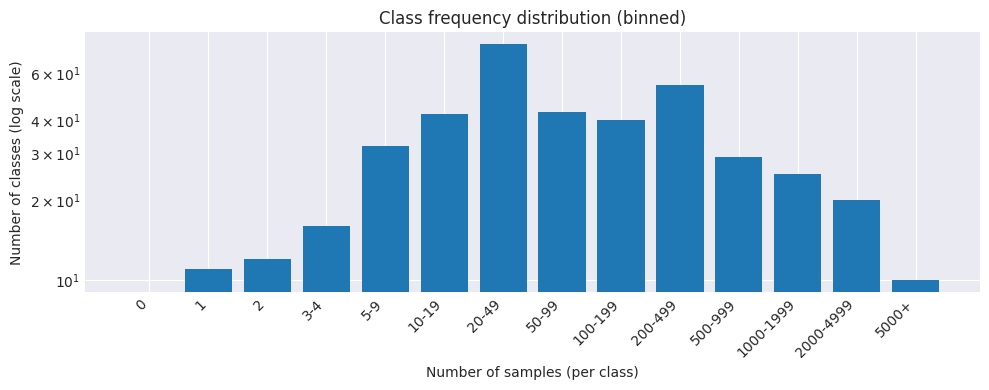

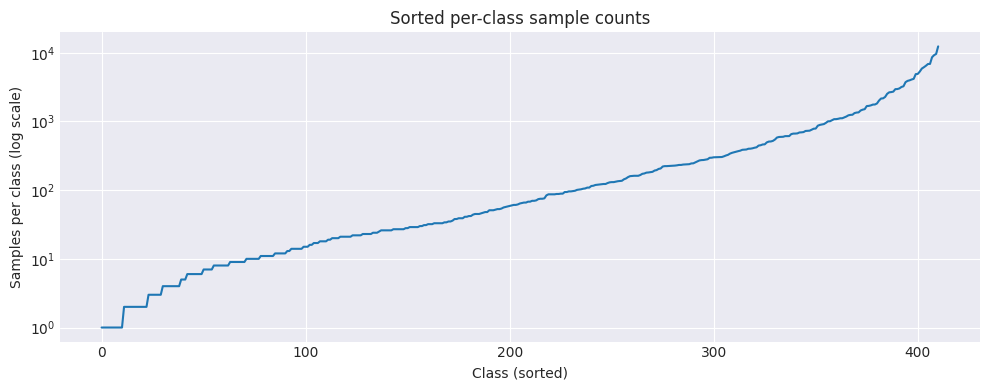

In [9]:
from uncertainbird.utils.plotting import plot_class_frequency

plot_class_frequency(targets_targetclasses)

In [10]:
from uncertainbird.utils.plotting import print_metrics

metrics_targetclasses = print_metrics(predictions_targetclasses, targets_targetclasses)

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.bucketize(confidences, bin_boundaries, right=True) - 1


Accuracy: tensor(0.9986)
cmAP: tensor(0.3922)
Precision: tensor(0.5418)
Recall: tensor(0.1408)
F1 Score: tensor(0.1951)
AUROC: tensor(0.9655)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.0076)
ECE Top-3: tensor(0.0246)
ECE Top-5: tensor(0.0189)
ECE Top-10: tensor(0.0137)
ECE Top-21: tensor(0.0092)
Miscalibration Score (MCS): tensor(-0.0071)
ECE Under-confidence: tensor(0.0074)
ECE Over-confidence: tensor(0.0002)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = 0.76%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

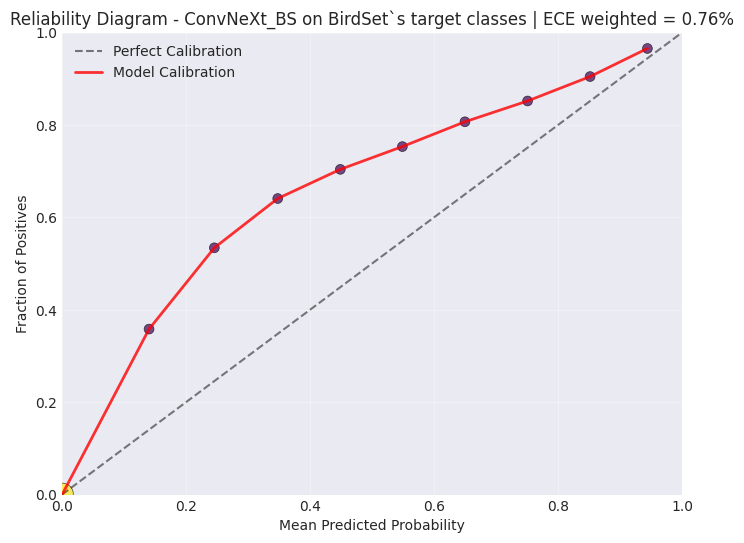

In [11]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions_targetclasses,
    targets_targetclasses,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = {metrics_targetclasses['ece_weighted']*100:.2f}%",
)

## Class-wise Calibration Plots

In [12]:
# only select classes with target labels
for key in list(data.keys()):
    # keep the dict structure; only replace the predictions/targets tensors
    preds = data[key]["predictions"][:, targets.sum(dim=0).gt(0)]
    tars = data[key]["targets"][:, targets.sum(dim=0).gt(0)]
    data[key]["predictions"] = preds
    data[key]["targets"] = tars
    # metadata and color remain unchanged

In [13]:
# compute metrics
for key in data:
    print("Computing metrics for", key)
    preds = data[key]["predictions"]
    tar = data[key]["targets"]
    data[key]["metrics"] = print_metrics(preds, tar)

Computing metrics for HSN


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9989)
cmAP: tensor(0.5345)
Precision: tensor(0.0333)
Recall: tensor(0.0116)
F1 Score: tensor(0.0149)
AUROC: tensor(0.0459)
ECE: tensor(0.0011)
ECE Weighted: tensor(0.0950)
ECE Top-3: tensor(0.0966)
ECE Top-5: tensor(0.0729)
ECE Top-10: tensor(0.0385)
ECE Top-21: tensor(0.0193)
Miscalibration Score (MCS): tensor(-0.0949)
ECE Under-confidence: tensor(0.0949)
ECE Over-confidence: tensor(8.3971e-05)
Computing metrics for NBP
Accuracy: tensor(0.9968)
cmAP: tensor(0.6424)
Precision: tensor(0.1050)
Recall: tensor(0.0307)
F1 Score: tensor(0.0450)
AUROC: tensor(0.1143)
ECE: tensor(0.0027)
ECE Weighted: tensor(0.0262)
ECE Top-3: tensor(0.0388)
ECE Top-5: tensor(0.0363)
ECE Top-10: tensor(0.0361)
ECE Top-21: tensor(0.0331)
Miscalibration Score (MCS): tensor(-0.0249)
ECE Under-confidence: tensor(0.0255)
ECE Over-confidence: tensor(0.0007)
Computing metrics for NES
Accuracy: tensor(0.9990)
cmAP: tensor(0.4008)
Precision: tensor(0.0985)
Recall: tensor(0.0342)
F1 Score: tensor(0.04

### Reliability Diagram
```

#### Combined

<Axes: title={'center': 'Combined Reliability Diagram - ConvNeXt_BS on BirdSet'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

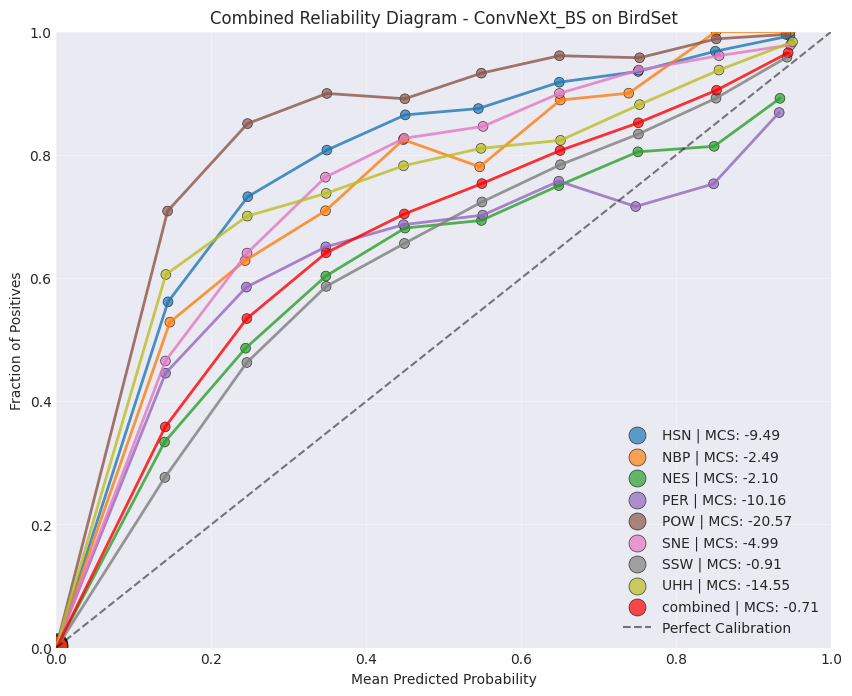

In [14]:
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# add average / combined data of all datasets
data["combined"] = {
    "predictions": predictions_targetclasses,
    "targets": targets_targetclasses,
    "metadata": None,
    "metrics": metrics_targetclasses,
    "color": "red",  # color for combined plot
}

plot_combined_reliability_diagram(
    data, n_bins=10, title="Combined Reliability Diagram - ConvNeXt_BS on BirdSet"
)

#### Per class

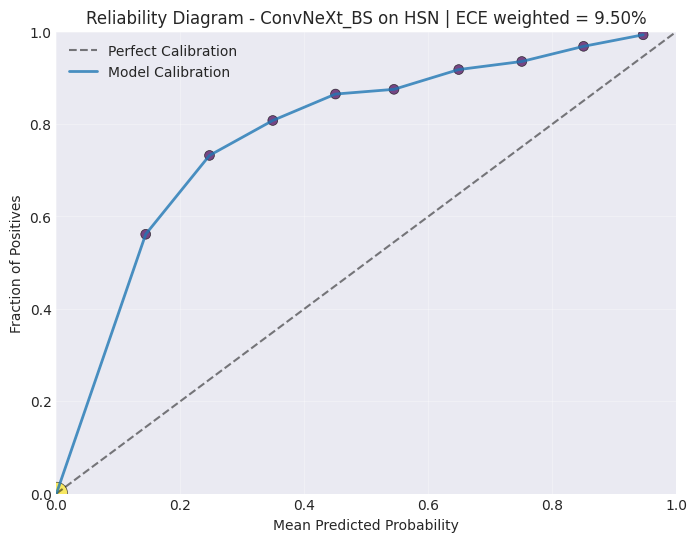

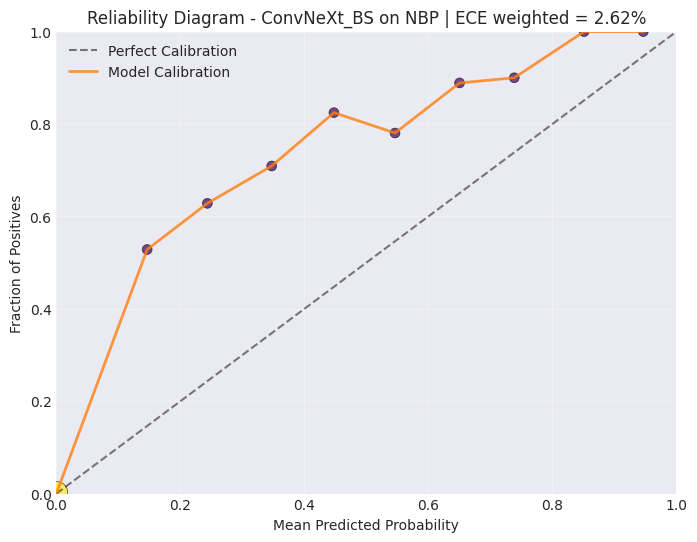

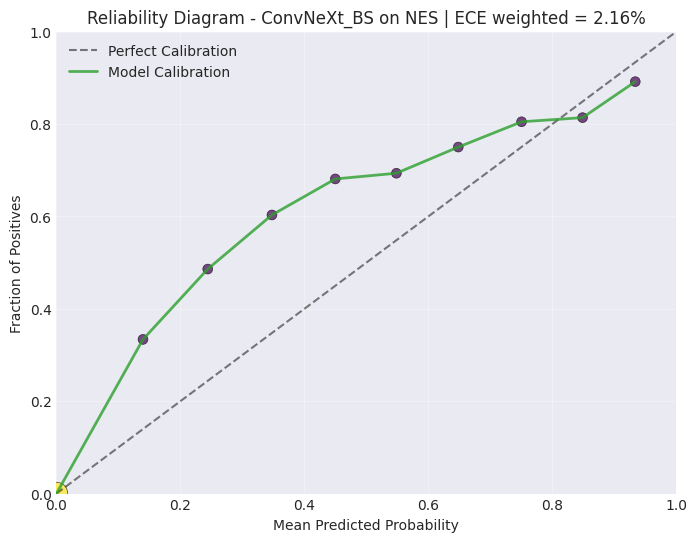

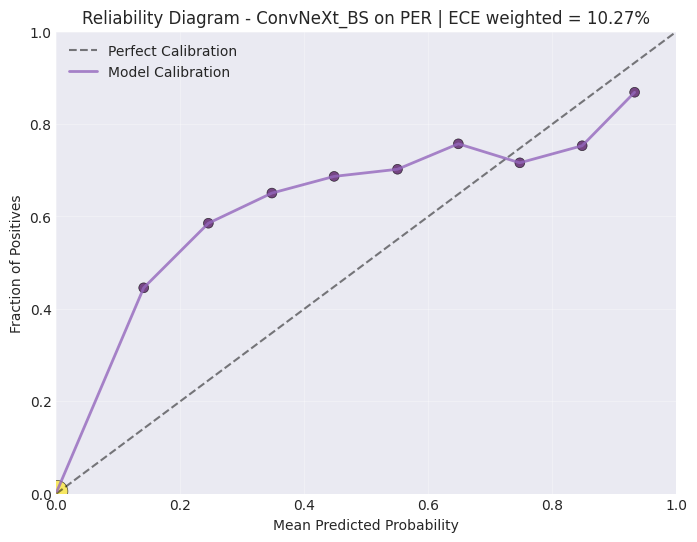

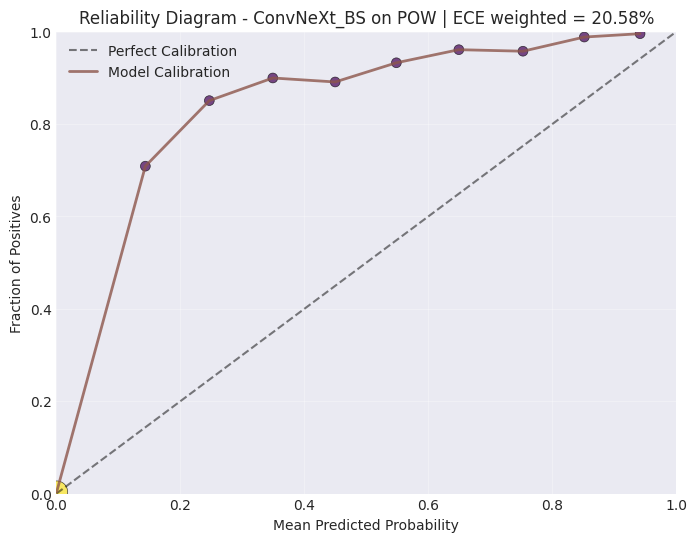

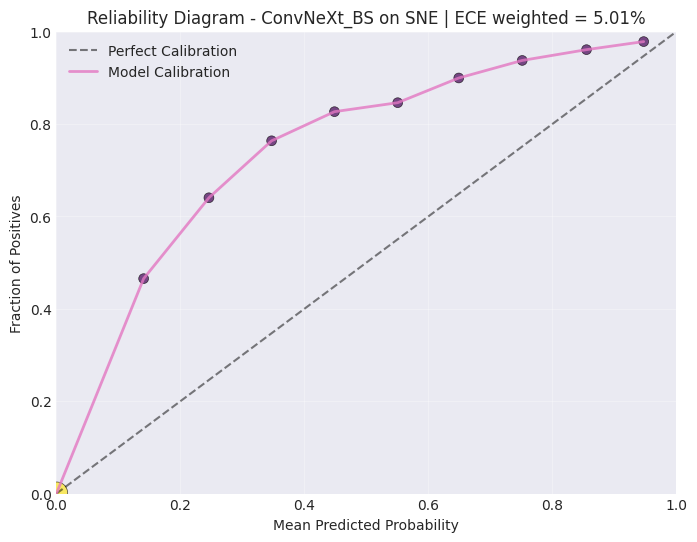

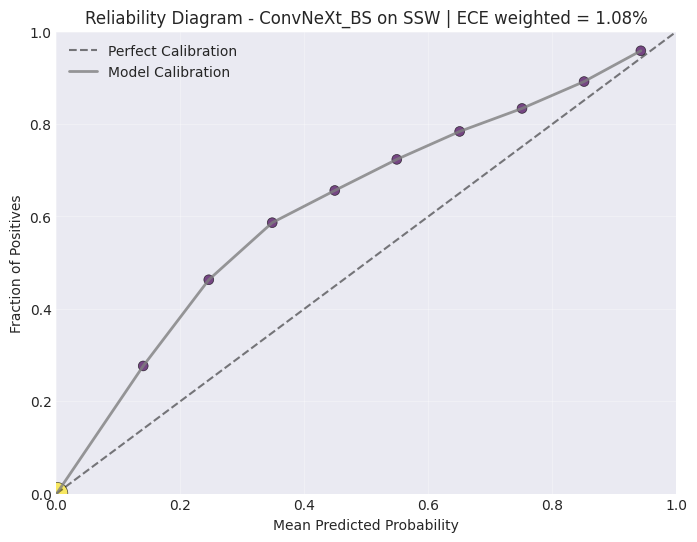

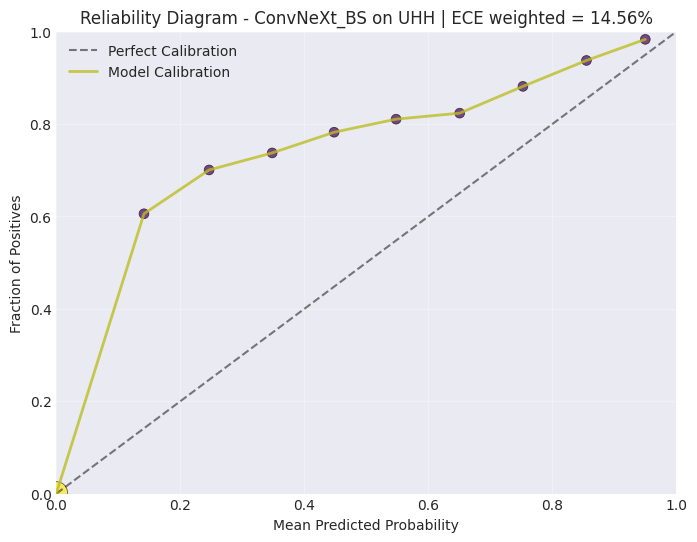

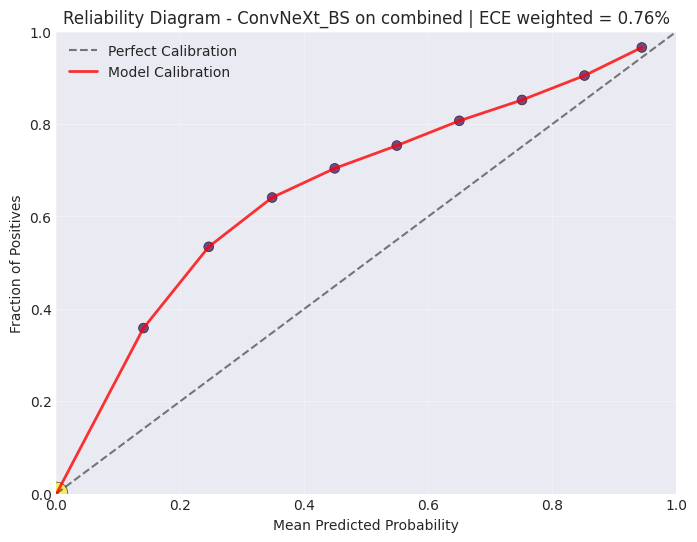

In [15]:
for key in data:
    plot_reliability_diagram(
        data[key]["predictions"],
        data[key]["targets"],
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {key} | ECE weighted = {data[key]['metrics']['ece_weighted']*100:.2f}%",
        color=data[key].get("color", "red"),
    )

In [21]:
from uncertainbird.utils.misc import class_wise_statistics

preds = predictions_targetclasses.float()
tar = targets_targetclasses.int()

class_stats = class_wise_statistics(preds, tar, n_bins=10)

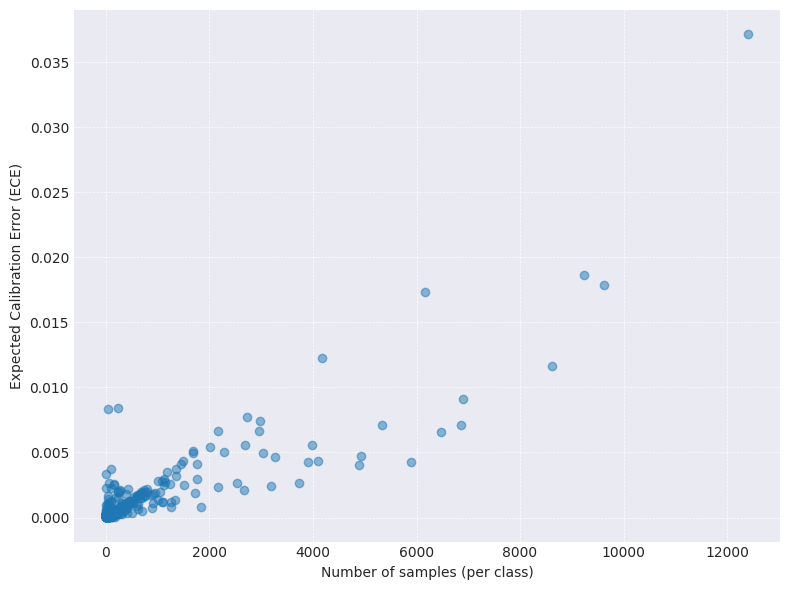

In [25]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["ece"], alpha=0.5)

plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
# plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

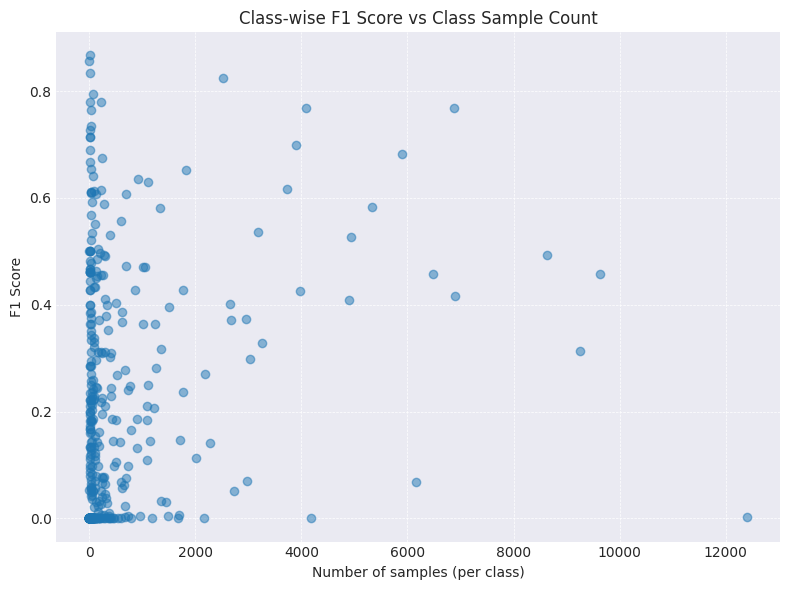

In [18]:
# f1 vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["f1_score"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()

In [19]:
# print cmAP for each dataset in the format "Dataset: <name>, cmAP: <value>"
print("cmAP per dataset:")
for key in data:
    print(f"Dataset: {key}, cmAP: {data[key]['metrics']['cmAP']*100:.2f}")

print("ECE for each dataset:")
for key in data:
    print(f"Dataset: {key}, ece: {data[key]['metrics']['ece_weighted']*100:.2f}")
print("MCS for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['mcs']*100:.2f}")
print("Under confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_under']*100:.2f}")
print("Over confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_over']*100:.2f}")

cmAP per dataset:
Dataset: HSN, cmAP: 53.45
Dataset: NBP, cmAP: 64.24
Dataset: NES, cmAP: 40.08
Dataset: PER, cmAP: 22.69
Dataset: POW, cmAP: 49.79
Dataset: SNE, cmAP: 31.89
Dataset: SSW, cmAP: 46.56
Dataset: UHH, cmAP: 38.58
Dataset: combined, cmAP: 39.22
ECE for each dataset:
Dataset: HSN, ece: 9.50
Dataset: NBP, ece: 2.62
Dataset: NES, ece: 2.16
Dataset: PER, ece: 10.27
Dataset: POW, ece: 20.58
Dataset: SNE, ece: 5.01
Dataset: SSW, ece: 1.08
Dataset: UHH, ece: 14.56
Dataset: combined, ece: 0.76
MCS for each dataset:
Dataset: HSN, mcs: -9.49
Dataset: NBP, mcs: -2.49
Dataset: NES, mcs: -2.10
Dataset: PER, mcs: -10.16
Dataset: POW, mcs: -20.57
Dataset: SNE, mcs: -4.99
Dataset: SSW, mcs: -0.91
Dataset: UHH, mcs: -14.55
Dataset: combined, mcs: -0.71
Under confidence score for each dataset:
Dataset: HSN, mcs: 9.49
Dataset: NBP, mcs: 2.55
Dataset: NES, mcs: 2.13
Dataset: PER, mcs: 10.21
Dataset: POW, mcs: 20.57
Dataset: SNE, mcs: 5.00
Dataset: SSW, mcs: 0.99
Dataset: UHH, mcs: 14.55
Datase